In [33]:
# you might need this if you are on a mac
#import pytensor
#pytensor.config.cxx = "/usr/bin/clang++"

In [34]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pandas as pd
#import plotly.express as px

In [35]:
sns.set()

## Factory data

The following dataset contains quality control measurements from 6
machines in a factory (range: 0-120, units of the measurements are irrelevant here).

In the dataset, each column contains the measurements for a single machine. Quality control measurements are expensive and time-consuming, so only 5 measurements were done for each machine.

In addition to the existing machines, we are interested in the quality of another machine (the seventh machine) which is not in the dataset.

In [36]:
df_wide = pd.read_csv("https://raw.githubusercontent.com/gcorani/bda/refs/heads/main/lab/05_pooled_unpooled_hierarchical_selection/factory.csv") # for use in colab
#df_wide = pd.read_csv("factory.csv")
df_wide.set_index("measurement", inplace=True)
df_wide.columns.name = "machine"
df_wide

machine,M0,M1,M2,M3,M4,M5
measurement,,,,,,
0,83.0,117.0,101.0,105.0,79.0,57.0
1,92.0,109.0,93.0,119.0,97.0,92.0
2,92.0,114.0,92.0,116.0,103.0,104.0
3,46.0,104.0,86.0,102.0,79.0,77.0
4,67.0,87.0,67.0,116.0,92.0,100.0


* Transform the dataset to the long format: one row per machine per measurement

A "long" format is more convenient for the following analyises. Let us *melt* the dataframe!

In [37]:
df = pd.melt(df_wide.reset_index(),
             id_vars=["measurement"],
             value_vars=['M0', 'M1', 'M2', 'M3', 'M4', 'M5'],
             value_name='quality')
df["machine"] = df["machine"].astype("category") # useful for group analysis (with pymc)

In [38]:
df.head(6)

,measurement,machine,quality
0,0,M0,83.0
1,1,M0,92.0
2,2,M0,92.0
3,3,M0,46.0
4,4,M0,67.0
5,0,M1,117.0


Note: the category column has the useful properies `cat.categories` (all the possible values of the categorical variable) and `cat.codes` (an equivalent integer representation of the variable)

In [39]:
df["machine"].cat.categories

Index(['M0', 'M1', 'M2', 'M3', 'M4', 'M5'], dtype='object')

In [40]:
df["machine"].cat.codes.head(6)

,0
0,0
1,0
2,0
3,0
4,0
5,1


## Some traditional data analysis (data-challenge style)

* Obtain the global mean and standard deviation of the quality measurement (pooled mean/standard deviation)

In [41]:
df["quality"].mean(), df["quality"].std()

(92.93333333333334, 18.001787906096773)

* Plot a histogram and a boxplot of the quality measurement

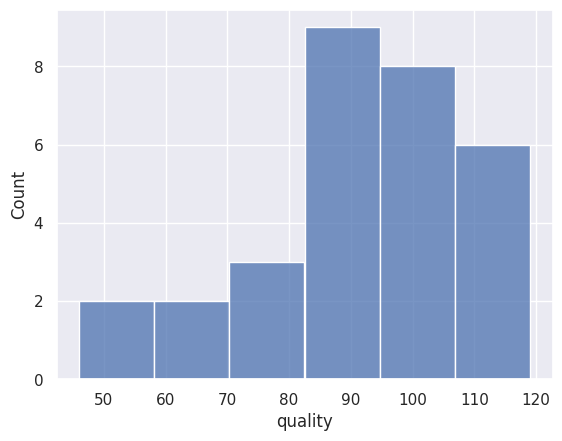

In [42]:
sns.histplot(df["quality"]);
#px.histogram(df["quality"]);

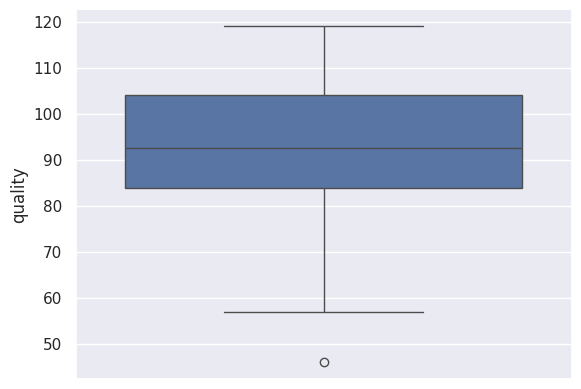

In [43]:
sns.boxplot(df["quality"]);

* Obtain the mean and standard deviation of quality measurement, for the different machines (unpooled mean/standard deviation)

In [44]:
df.groupby("machine")[["quality"]].agg(["mean", "std"])

<ipython-input-44-2a4a555e1d27>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("machine")[["quality"]].agg(["mean", "std"])


quality           
           mean        std
machine                   
M0         76.0  19.634154
M1        106.2  11.819475
M2         87.8  12.794530
M3        111.6   7.569676
M4         90.0  10.770330
M5         86.0  19.222383

* Draw boxplots of quality for the different factories

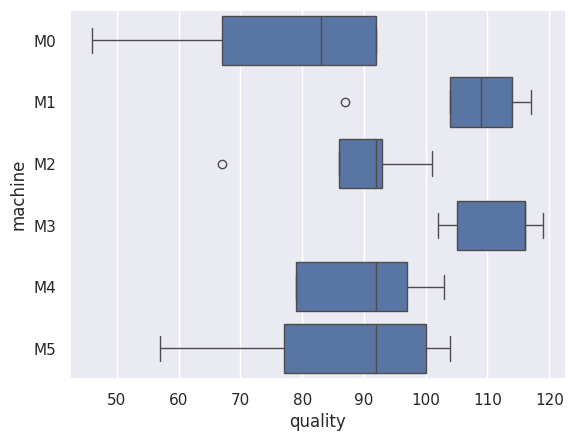

In [45]:
sns.boxplot(data=df, x="quality", y="machine");
#px.box(df, x="quality", y="machine")

Even from a classical analysis, there seems to be evidence that different machines have different quality.

## Pooled Bayesian Model

Consider the following *pooled* Bayesian model:
\begin{align*}
\mu &\sim N(90, 10) \\
\sigma &\sim \text{HalfNormal}(36) \\
\vec{y}_{ij} &\sim N(\mu, \sigma) \\
\end{align*}


* Discuss the pooled model and its underlying hypotheses

The model does not make distinction between different machines. It is a single normal-normal model for measurements from all the different machines; it assumes the measurement to share *global* mean and standard deviation $\mu$ and $\sigma$, respectively.

It could have been constructed assuming that:
1. The (global) mean quality $\mu$ is between $90-3*10=60$ and $90+3*10=120$ with probability 99%
2. All quality measurements $\vec{y}_{ij}$ are in a range of width $25*6=150$ with probability 99%


In [46]:
pd.DataFrame(stats.halfnorm.rvs(size=10_000, scale=36)).median()

,0
0,23.925988


* Implement the pooled model in pymc

In [47]:
with pm.Model() as model_pooled:
    global_mu = pm.Normal('global_mu', mu=90, sigma=15)
    global_sigma = pm.HalfNormal('global_sigma', sigma=30)
    y = pm.Normal('y', mu=global_mu, sigma=global_sigma, observed=df["quality"])
    trace_pooled = pm.sample(10_000, idata_kwargs = {'log_likelihood': True})

Output()

Output()

In [48]:
#pm.model_to_graphviz(model_pooled)

In [49]:
with model_pooled:
    display(az.summary(trace_pooled))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mu,92.810,3.340,86.521,99.080,0.025,0.018,17493.0,13546.0,1.0
global_sigma,18.669,2.549,14.106,23.424,0.020,0.014,16721.0,13636.0,1.0


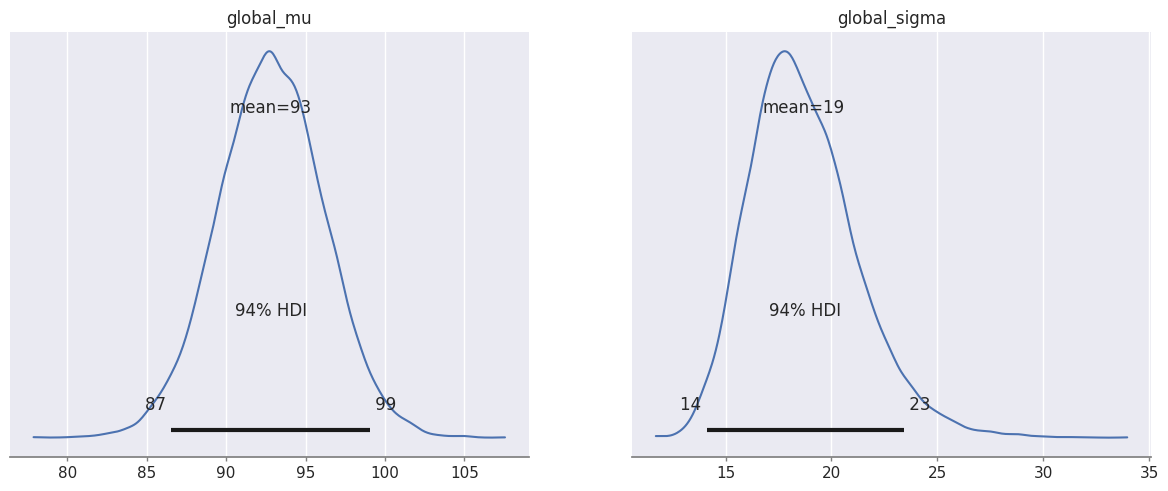

In [50]:
with model_pooled:
    az.plot_posterior(trace_pooled);

## Unpooled Bayesian Model

Consider the following Bayesian unpooled model
\begin{align*}
\mu_{j} &\sim {N}(90, 20) \\
\sigma_{j} &\sim \text{HalfNormal}(23) \\
\vec{y}_{ij} &\sim {N}(\mu_j, \sigma_j) \\
\end{align*}

* Discuss the unpooled model and its underlying hypotheses

The unpooled model actually consists in 6 completely separate normal-normal sub-models for the 6 different machines.
It could have build according to the hipotheses that:
1. The mean quality of each machine is between $90-3*20=30$ and $90+3*20=150$ with probability 99%
2. The quality measurements of each machine are in a range of width $15*6=90$ with probability 99%

In [51]:
pd.DataFrame(stats.halfnorm.rvs(size=10_000, scale=23)).median()

,0
0,15.57182


* Implement the unpooled model in pymc

In [52]:
#df["machine_id"] = df["machine"].cat.codes
machines = list(df["machine"].cat.categories)
n_machines = len(machines) # number of machines (6)
machines, n_machines

(['M0', 'M1', 'M2', 'M3', 'M4', 'M5'], 6)

In [53]:
with pm.Model() as model_unpooled:
    group_mu = pm.Normal('group_mu', mu=90, sigma=20, shape=n_machines)
    group_sigma = pm.HalfNormal('group_sigma', sigma=23, shape=n_machines)
    #y = pm.Normal('y', mu=group_mu[df["machine_id"]], sd=group_sigma[df["machine_id"]], observed=df["quality"])
    y = pm.Normal('y', mu=group_mu[df["machine"].cat.codes],
                       sigma=group_sigma[df["machine"].cat.codes],
                       observed=df["quality"])
    trace_unpooled = pm.sample(10_000, idata_kwargs = {'log_likelihood': True})


Output()

Output()

ERROR:pymc.stats.convergence:There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [54]:
#pm.model_to_graphviz(model_unpooled)

In [55]:
trace_unpooled.posterior = trace_unpooled.posterior.assign_coords(group_mu_dim_0=machines,
                                                                  group_sigma_dim_0=machines)

In [56]:
with model_unpooled:
    display(az.summary(trace_unpooled))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_mu[M0],78.722,9.070,61.382,95.975,0.061,0.044,22910.0,13250.0,1.0
group_mu[M1],104.361,6.698,91.731,117.353,0.053,0.038,17863.0,10610.0,1.0
group_mu[M2],88.029,6.989,74.722,101.586,0.056,0.039,17207.0,12167.0,1.0
group_mu[M3],110.325,4.992,101.068,119.945,0.043,0.031,15701.0,10175.0,1.0
group_mu[M4],90.035,6.144,78.527,102.014,0.045,0.032,20070.0,12553.0,1.0
group_mu[M5],86.720,8.800,69.258,102.654,0.056,0.040,24851.0,13774.0,1.0
group_sigma[M0],22.212,7.435,10.698,36.014,0.050,0.038,26226.0,16576.0,1.0
group_sigma[M1],15.218,6.096,6.420,26.542,0.050,0.037,18095.0,14304.0,1.0
group_sigma[M2],16.023,6.327,6.920,27.698,0.049,0.037,21057.0,14323.0,1.0
group_sigma[M3],10.607,5.083,4.228,19.839,0.045,0.033,17439.0,12284.0,1.0


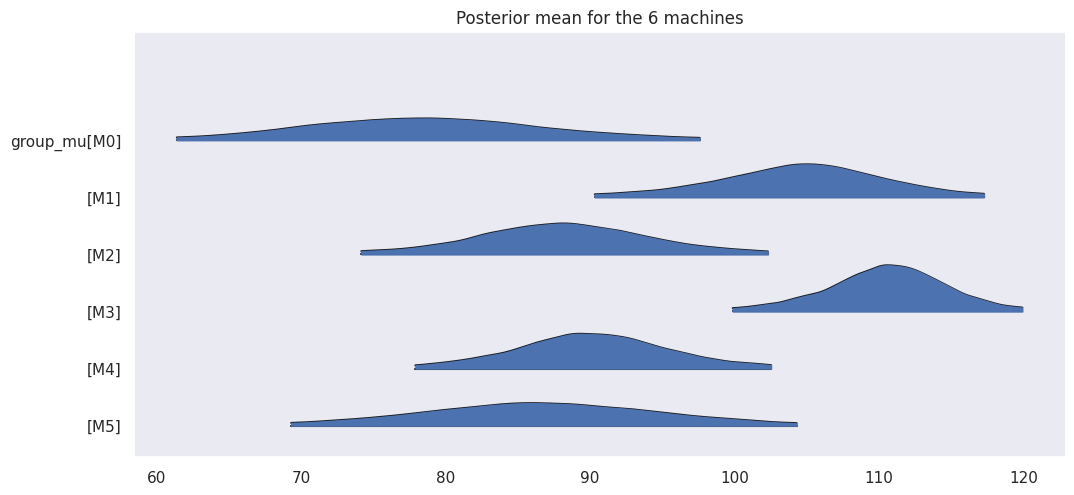

In [57]:
with model_unpooled:
    axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.95, var_names="group_mu", combined=True);
    plt.title("Posterior mean for the 6 machines")
    #axes[0].set_yticklabels(machines[::-1])


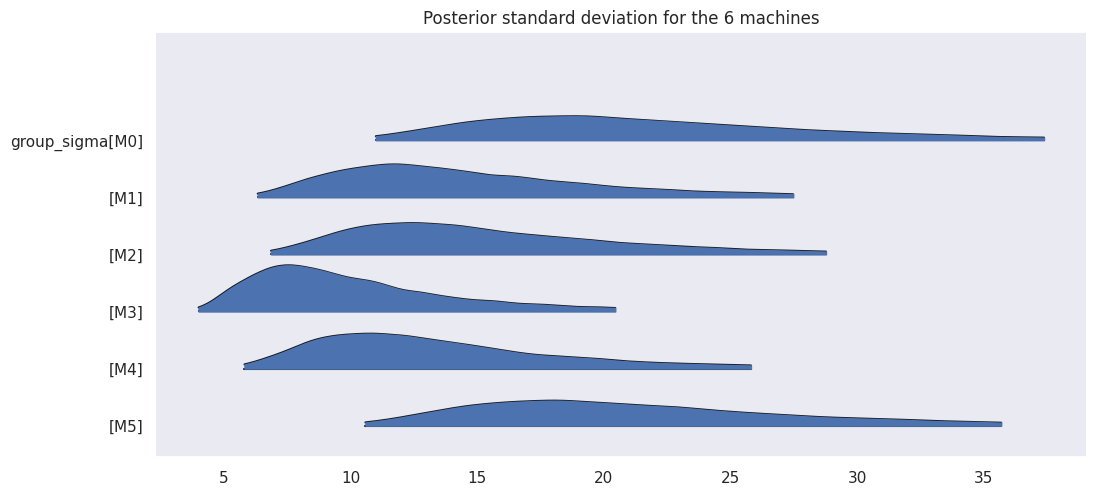

In [58]:
with model_unpooled:
    axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.95, var_names="group_sigma", combined=True);
    plt.title("Posterior standard deviation for the 6 machines")
    #axes[0].set_yticklabels(machines[::-1])

* Compare the sample unpooled standard deviation with the Bayesian estimate. What do you observe?

We already computed the sample standard deviations before:

In [59]:
df.groupby("machine")[["quality"]].agg(["mean", "std"])

<ipython-input-59-2a4a555e1d27>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("machine")[["quality"]].agg(["mean", "std"])


quality           
           mean        std
machine                   
M0         76.0  19.634154
M1        106.2  11.819475
M2         87.8  12.794530
M3        111.6   7.569676
M4         90.0  10.770330
M5         86.0  19.222383

The posterior means of the bayesian estimates are:

In [60]:
with model_unpooled:
    display(az.summary(trace_unpooled, var_names=["group_sigma"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_sigma[M0],22.212,7.435,10.698,36.014,0.050,0.038,26226.0,16576.0,1.0
group_sigma[M1],15.218,6.096,6.420,26.542,0.050,0.037,18095.0,14304.0,1.0
group_sigma[M2],16.023,6.327,6.920,27.698,0.049,0.037,21057.0,14323.0,1.0
group_sigma[M3],10.607,5.083,4.228,19.839,0.045,0.033,17439.0,12284.0,1.0
group_sigma[M4],13.986,5.860,5.866,24.928,0.047,0.036,20015.0,13531.0,1.0
group_sigma[M5],21.633,7.180,10.801,34.905,0.050,0.038,23802.0,16274.0,1.0


In [ ]:
# az.plot_posterior(trace_separate["group_std"][:, 0], point_estimate='mode')
with model_unpooled:
    az.plot_posterior(trace_unpooled, var_names=["group_sigma"], point_estimate='mode'); # the posterior mean is 29, the mode is 19!

The sample std is rather different from the posterior std mean. The sample std is actually much similar to the posterior mode (as expected from theory)! The posterior std distributions are heavily right-skewed!

## Hierarchical model, common std

Consider the following Bayesian hierarchical model:

\begin{align*}
\mu_\mu & \sim N(90, 10)\\
\sigma_\mu  & \sim \text{HalfNormal}(30) \\
\mu_{j} &\sim {N}(\mu_\mu, \sigma_\mu) \\
\sigma &\sim \text{HalfNormal}(23) \\
\vec{y}_{ij} &\sim {N}(\mu_j, \sigma) \\
\end{align*}



* Discuss the hierarchical model and its underlying hypotheses

The hierarchical model may be seen as an extension of the unpooled model. While in the unpooled model the 6 different $\mu_j$ are independent of each other, in the hierarchical model they share common parent variabes $\mu_\mu$ and $\sigma_\mu$ representing our prior belief about their mean value and their spread, respectively. Indeed, each $\mu_j$ is assumed to be normal with mean $\mu_\mu$ and standard deviation $\sigma_\mu$. Furthermore, we assume a single random variable $\sigma$ modeling the spread of the different measurements for a given machine (note that in the previous unpooled model we had different standard deviation parameters for the different groups, it is kind of an arbitrary choice/modeling assumption).

From the numerical values of the model coefficients, the modeler might have made the following assumptions:
1. The mean of the mean quality of each machine is between $90-3*10=60$ and $90+3*10=120$ with probability 99% $\Rightarrow$ from $\mu_\mu \sim N(90, 10)$
2. The quality measurements of each machine are in a range of width $15*6=90$ with probability 99% $\Rightarrow$ from $\sigma \sim \text{HalfNormal}(23)$
3. The different $\mu_j$ vary in a range of width $6*20=120$ with probability 99% $\Rightarrow$ from $\sigma_\mu  \sim \text{HalfNormal}(30)$

In [ ]:
pd.DataFrame(stats.halfnorm.rvs(size=10_000, scale=23)).median()

In [ ]:
pd.DataFrame(stats.halfnorm.rvs(size=10_000, scale=30)).median()

* Implement the hierarchical model in pymc

In [ ]:
with pm.Model() as model_hierarchical:

    # hyper_priors
    mu_mu = pm.Normal('mu_mu', mu=90, sigma=10)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma=30)

    # priors
    group_mu = pm.Normal('group_mu', mu=mu_mu, sigma=sigma_mu, shape=n_machines)
    global_std = pm.HalfNormal('global_std', sigma=23)
    y = pm.Normal('y', mu=group_mu[df["machine_id"]],
                       sigma=global_std, observed=df["quality"])
    trace_hierarchical = pm.sample(10_000, idata_kwargs = {'log_likelihood': True})

In [ ]:
#pm.model_to_graphviz(model_hierarchical)

In [ ]:
trace_hierarchical.posterior = trace_hierarchical.posterior.assign_coords(group_mu_dim_0=machines)

In [ ]:
az.summary(trace_hierarchical)

## Model selection

What is the best model ultimately? In our case: Pooled, Unpooled, or Hierarchical?


To answer this question, we need a **model selection** strategy/metric.

* You know metrics for point regression models (mse, rmse, mae,...)
* You know metrics for point classification models (accuracy, prediciton, recall...)


### The WAIC Criterion
To score full Bayesian models, we need a metric that evaluates a (sample-based approximation of a) *distribution*.

* A popular metric to score a distribution is the log-pointwise-predictive-density ${\rm lpd}(y, \Theta)$:
$$ {\rm lpd}(y, \Theta) = \sum_i \log \frac{1}{S} \sum_s p(y_i | \Theta_s),$$
where $y$ are the observations and $\Theta$ is the sample-based approximation of the posterior ($\Theta_s$ is a single MCMC draw). It is the (approximate) logarithm of the expected likelihood (the higher, the better)!


* The ${\rm lpd}(y, \Theta)$ generally increases for increasing model complexity and it is thus prone to overfitting when used on the same data used for model building. It should be evaluated with fresh data in (cross)-validation.

* The WAIC criterion (the lower, the better) balances high ${\rm lpd}$ and low model complexity explicitly. It can be applied directly on the training data $y$!

\begin{align}
{\rm WAIC}(y, \Theta) &= -2(\rm{lpd} - p_{\rm waic}).\\
 p_{{\rm waic}} &= \sum_i {\rm var}_{\theta} \log p(y_i|\theta)
\end{align}

* The WAIC is equivalent up to a factor to the ${\rm elpd}$, the *expected* $\rm{lpd}$ on fresh data (the higher, the better):

$${\rm elpd}(y, \Theta) = \rm{lpd} - p_{\rm waic}.$$

Advantages of WAIC/elpd:

* Well-defined both for continuous and for categorical observations
* Applicable to Bayesian models returning point-wise estimates
* Applicable to the training data directly (built-in complexity penalty)
* Works well in practice

Note: WAIC stands for Widely Applicable Information Criterion!

### The WAIC Criterion in arviz

Arviz has a built-in function `az.waic` to compute the WAIC (actually, as of v0.12.1, arviz computes the ${\rm elpd}$, see <a href="https://python.arviz.org/en/v0.12.1/api/generated/arviz.waic.html?highlight=waic">documentation</a>):


In [ ]:
az.waic(trace_pooled)

There is an even more convenient method to evaluate the criterion on several models and rank them according to the WAIC criterion (from best to worst, ascending WAIC/descending elpd)

In [ ]:
#with factory_pooled, factory_separate, factory_hierarchical:
comp_df = az.compare({"model_pooled": trace_pooled,
                      "model_unpooled": trace_unpooled,
                      "model_hierarchical": trace_hierarchical},
                      ic="waic") # ic stands for "information criterion"
comp_df

In [ ]:
az.plot_compare(comp_df);

## Posterior predictions of new measurements

* Given the pooled model, make a prediction for a new measurement

We can do it by adding a line in pymc corresponding to the prediction:

In [ ]:
with pm.Model() as model_pooled_with_pred:

    global_mu = pm.Normal('global_mu', mu=90, sigma=15)
    global_sigma = pm.HalfNormal('global_sigma', sigma=30)
    y = pm.Normal('y', mu=global_mu, sigma=global_sigma, observed=df["quality"])

    y_pred = pm.Normal("y_pred", mu=global_mu, sigma=global_sigma)

    trace_pooled_with_pred = pm.sample(10_000, return_inferencedata=True)

In [ ]:
with model_pooled_with_pred:
    display(az.summary(trace_pooled_with_pred)) # var_names='y_pred'

Otherwise, we can play with the trace directly. For each sampled value of global_mu and global_sigma, we sample from
N(global_mu, global_sigma)

In [ ]:
post_pooled = az.extract(trace_pooled.posterior)

y_pred = np.zeros_like(post_pooled.global_mu.values)
for idx in range(y_pred.shape[0]):
    y_pred[idx] = scipy.stats.norm.rvs(loc=post_pooled.global_mu.values[idx],
                                       scale=post_pooled.global_sigma.values[idx])

#y_pred = scipy.stats.norm.rvs(loc=post_pooled.global_mu.values,scale=post_pooled.global_sigma.values) # faster vectorized implementation!

y_pred.mean(), y_pred.std() # similar to y_pred in the trace (note: there is randomness!)

* Given the unpooled model, make a prediction for a new measurement of the machine M1

In [ ]:
with pm.Model() as model_unpooled_with_pred_M1:
    group_mu = pm.Normal('group_mu', mu=90, sigma=20, shape=n_machines)
    group_sigma = pm.HalfNormal('group_sigma', sigma=23, shape=n_machines)
    y = pm.Normal('y', mu=group_mu[df["machine"].cat.codes],
                  sigma=group_sigma[df["machine"].cat.codes],
                  observed=df["quality"])

    y_M1_pred = pm.Normal('y_M1', mu=group_mu[0], sigma=group_sigma[0])

    trace_unpooled_with_pred_M1 = pm.sample(10_000, return_inferencedata=True)


In [ ]:
with model_unpooled_with_pred_M1:
    display(az.summary(trace_unpooled_with_pred_M1, var_names="y_M1"))

In [ ]:
post_unpooled = az.extract(trace_unpooled.posterior)
y_M1_pred = scipy.stats.norm.rvs(loc=post_unpooled.group_mu[0].values,
                                 scale=post_unpooled.group_sigma[0].values)
y_M1_pred.mean(), y_M1_pred.std() # similar to y_pred in the trace (note: there is randomness!)